In [5]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans


class CorrelationNetwork:
    def fit(self, X):
        self.p = X.shape[-1]
        self.regs = [[LinearRegression() for _ in range(self.p)] for _ in range(self.p)]
        for i in range(self.p):
            for j in range(self.p):
                self.regs[i][j].fit(X[:, j, np.newaxis], X[:, i, np.newaxis])
        return self
    
    def predict(self, n):
        betas = np.zeros((self.p, self.p))
        for i in range(self.p):
            for j in range(self.p):
                betas[i, j] = self.regs[i][j].coef_.squeeze()
        corrs = betas * betas.T
        return np.tile(np.expand_dims(corrs, axis=0), (n, 1, 1))
    
    def mses(self, X):
        mses = np.zeros(len(X))
        for i in range(self.p):
            for j in range(self.p):
                residual = self.regs[i][j].predict(X[:, j, np.newaxis]) - X[:, i, np.newaxis]
                residual = residual[:, 0]
                mses += (residual ** 2) / self.p**2
        return mses
    

class MarkovNetwork:
    def fit(self, X):
        self.p = X.shape[-1]
        self.regs = [LinearRegression() for _ in range(self.p)]
        for i in range(self.p):
            mask = np.ones_like(X)
            mask[:, i] = 0
            self.regs[i].fit(X * mask, X[:, i, np.newaxis])
        return self
    
    def predict(self, n):
        betas = np.zeros((self.p, self.p))
        for i in range(self.p):
            betas[i] = self.regs[i].coef_.squeeze()
            betas[i, i] = 0
        precision = - np.sign(betas) * np.sqrt(np.abs(betas * betas.T))
        return np.tile(np.expand_dims(precision, axis=0), (n, 1, 1))
    
    def mses(self, X):
        mses = np.zeros(len(X))
        for i in range(self.p):
            mask = np.ones_like(X)
            mask[:, i] = 0
            residual = self.regs[i].predict(X * mask) - X[:, i, np.newaxis]
            residual = residual[:, 0]
            mses += (residual ** 2) / self.p
        return mses


class GroupedNetworks:
    def __init__(self, model_class):
        self.model_class = model_class
    
    def fit(self, X, labels):
        self.models = {}
        self.p = X.shape[-1]
        for label in np.unique(labels):
            label_idx = labels == label
            X_label = X[label_idx]
            model = self.model_class().fit(X_label)
            self.models[label] = model
        return self
    
    def predict(self, labels):
        networks = np.zeros((len(labels), self.p, self.p))
        for label in np.unique(labels):
            label_idx = labels == label
            networks[label_idx] = self.models[label].predict(label_idx.sum())
        return networks
    
    def mses(self, X, labels):
        mses = np.zeros(len(X))
        for label in np.unique(labels):
            label_idx = labels == label
            X_label = X[label_idx]
            mses[label_idx] = self.models[label].mses(X_label)
        return mses


class ClusteredCorrelation:
    def __init__(self, K, clusterer=None):
        self.K = K
        if clusterer is None:
            self.kmeans = KMeans(n_clusters=K)
            self.prefit = False
        else:
            self.kmeans = clusterer
            self.prefit = True
        self.models = {k: PopulationCorrelation() for k in range(K)}
    
    def fit(self, C, X):
        self.p = X.shape[-1]
        if not self.prefit:
            self.kmeans.fit(C)
        labels = self.kmeans.predict(C)
        for k in range(self.K):
            k_idx = labels == k
            X_k, C_k = X[k_idx], C[k_idx]
            self.models[k].fit(C_k, X_k)
        return self
    
    def predict(self, C):
        labels = self.kmeans.predict(C)
        corrs = np.zeros((len(C), self.p, self.p))
        for label in np.unique(labels):
            l_idx = labels == label
            C_l = C[l_idx]
            corrs[l_idx] = self.models[label].predict(C_l)
        return corrs
    
    def mses(self, C, X):
        labels = self.kmeans.predict(C)
        mses = np.zeros(len(C))
        for label in np.unique(labels):
            l_idx = labels == label
            l_count = sum(l_idx)
            C_l, X_l = C[l_idx], X[l_idx]
            mses[l_idx] = self.models[label].mses(C_l, X_l)
        return mses


In [7]:
n, x_dim = 100, 20
labels = np.random.randint(0, 5, (n,))
X = np.random.uniform(-1, 1, (n, x_dim))

corr = CorrelationNetwork().fit(X)
corr.predict(n)
print(corr.mses(X).mean())

mark = MarkovNetwork().fit(X)
mark.predict(n)
print(mark.mses(X).mean())

grouped_corr = GroupedNetworks(CorrelationNetwork).fit(X, labels)
grouped_corr.predict(labels)
print(grouped_corr.mses(X, labels).mean())

grouped_mark = GroupedNetworks(MarkovNetwork).fit(X, labels)
grouped_mark.predict(labels)
print(grouped_mark.mses(X, labels).mean())

0.3065607347398675
0.2646665813126492
0.2830745940131997
0.02622722360951478


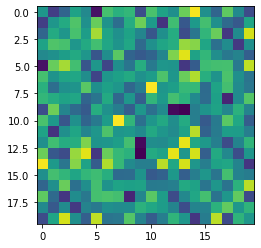

In [8]:
import matplotlib.pyplot as plt
plt.imshow(mark.predict(1)[0])
plt.show()

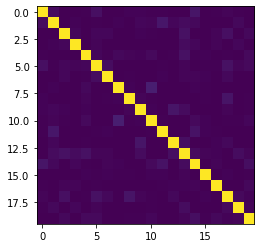

In [9]:
plt.imshow(corr.predict(1)[0])
plt.show()